# 1. Importieren der benötigten Bibliotheken



In [2]:
import os
import subprocess
import pandas as pd
import shutil
import tqdm
import glob
import pytest
import numpy as np
import matplotlib.pyplot as plt
import pydqc.data_compare as dc 
from joblib import Parallel, delayed
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import shapiro, binom_test, kstest, uniform
import numpy as np



# 2. Datenpreparation für das ML-Modell


## 2.1 Extrahieren der Bildpfade aus dem Ordner img_align_celeba 
##### Dies wird gemacht um die Pfade aus der Source-CSV: list_attr_celeba.csv in der Spalte image_id mit den richtigen Pfaden zu ersetzen. Somit sind die Pfade den Bildern richtig zugeordnet. 

In [3]:
source_csv = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\source_csv\list_attr_celeba.csv"
csv_path=r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\local_image_path_Gender.csv"
source_train_path = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\train"
men_image_source_path_train = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\train\men"
women_image_source_path_train = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\train\women"
men_image_source_path_test = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\val\men"
women_image_source_path_test = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\val\women"
merged_csv_test = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\csv_sheets\merged_df_test.csv"
merged_csv_train = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\csv_sheets\merged_df_train.csv"
required_directories = [source_train_path, women_image_source_path_test,men_image_source_path_test,men_image_source_path_train,women_image_source_path_train]

df = pd.read_csv(source_csv)
df.to_csv("source.csv", index=False)

# Hauptpfad zu den Bildern
base_path = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\img_align_celeba"

# Extrahiert aus dem Source Pfad die Bildpfade
def get_image_paths(source_path):
    image_formats = ['*.jpg', '*.png', '*.gif', '*.jpeg']
    image_paths = []
    for format in image_formats:
        image_paths.extend(glob.glob(os.path.join(source_path, format)))
    return image_paths

# Testet ob die Bilder in der CSV-Datei die richtigen Dateiendungen haben
def test_image_extensions_in_csv(csv_path, column_name_of_image_paths="image_id"):
    df = pd.read_csv(csv_path)

    # Überprüfe, ob alle Werte in der Spalte 'image_id' auf Bilddateien verweisen
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    df['valid_extension'] = df[column_name_of_image_paths].apply(lambda x: os.path.splitext(x)[1].lower() in valid_extensions)

    # Drucke die Zeilennummern mit ungültiger Dateierweiterung, wenn es welche gibt
    invalid_rows = df[~df['valid_extension']].index
    if len(invalid_rows) > 0:
        print(f'Ungültige Dateierweiterungen gefunden in den Zeilen: {invalid_rows.tolist()}')

    assert all(df['valid_extension']), f'Nicht alle Werte in der Spalte {column_name_of_image_paths} verweisen auf Bilddateien.\n {invalid_rows} \n Überprüfe die Dateierweiterungen.'

# Extrahieren der Bildpfade auf img_align_celeba
image_paths_array = get_image_paths(base_path)

# Erstellen eines Dataframes mit der Source CSV 
df = pd.read_csv(r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\source_csv\list_attr_celeba.csv")

# Alte image_id Spalte löschen.
df = df.drop(columns=["image_id"])

# Pfade aus image_id zu einer liste machen
columns = df.columns.tolist()


# base_path mit image_paths_array verbinden
join = pd.Series(image_paths_array).apply(lambda x: os.path.join(base_path, x))


df["image_id"] = join


# \ durch / ersetzen damit die Pfade richtig angeben werden
df['image_id'] = df['image_id'].str.replace("\\", "/")

# Get a list of the column names
cols = df.columns.tolist()

# Spalte image_id an den Anfang setzen
cols.insert(0, cols.pop(cols.index('image_id')))

# Reindexieren des Dataframes
df = df.reindex(columns=cols)

# Speichern der neuen CSV
df.to_csv(r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\source_csv\list_attr_celeba.csv", index=False)

## 2.2 Testen ob die Bildpfade in der CSV-Datei die richtige Dateiendung haben. 

In [17]:
csv_path = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\source_csv\list_attr_celeba.csv"
test_image_extensions_in_csv(csv_path=csv_path, column_name_of_image_paths="image_id")

## 2.3 Überprüfen ob die Source_CSV im Dateiformat CSV ist. 


In [18]:
def check_csv_extension(csv_path):
    _, ext = os.path.splitext(csv_path)
    assert ext.lower() == '.csv', f'Die Datei {csv_path} hat keine .csv Erweiterung'
    
check_csv_extension(csv_path)

## 2.4 Überprüfen ob die benötigten Ordner vorhanden sind zum trainieren, testen, speichern der ML-Modelle

In [19]:
def check_required_directories_data_exists(directories):
    for directory in directories:
        assert os.path.isdir(directory), f'Das Verzeichnis {directory} existiert nicht'

check_required_directories_data_exists(required_directories)

# 3 Datenqualität testen

## 3.1 Überprüfen ob Bilddateien fehlen, Duplicate vorhanden sind, Überprüfen ob die Bildpfade gültig sind in der CSV. 

In [20]:
def test_quality_of_csv(csv_path,column_name_of_image_paths="image_id"):
    df = pd.read_csv(csv_path)

    # Überprüfe auf fehlende Werte
    assert df[column_name_of_image_paths].isnull().sum() == 0, f'Es gibt fehlende Werte in der Spalte {column_name_of_image_paths}'

    # Überprüfe auf Duplikate
    assert df.duplicated().sum() == 0, "Es gibt Duplikate in der Daten"
    
    # Überprüfe, ob alle Werte in der Spalte 'image_id' gültige Bildpfade sind
    assert all(df[column_name_of_image_paths].apply(os.path.isfile)), f'Nicht alle Werte in der Spalte {column_name_of_image_paths} sind gültige Bildpfade.\n {df[column_name_of_image_paths].sample(10)} \n Überprüfe, ob der Pfad vorhanden ist.' 

test_quality_of_csv(source_csv, column_name_of_image_paths=df.columns[0])

## 3.2 Überprüfen ob es in allen Spalten Werte gibt die null bzw. leer sind.

In [21]:
def check_missing_values(csv_path):
    df = pd.read_csv(csv_path)
    missing_values = df.isnull().any()
    
    return missing_values

check_missing_values(source_csv)

image_id               False
5_o_Clock_Shadow       False
Arched_Eyebrows        False
Attractive             False
Bags_Under_Eyes        False
Bald                   False
Bangs                  False
Big_Lips               False
Big_Nose               False
Black_Hair             False
Blond_Hair             False
Blurry                 False
Brown_Hair             False
Bushy_Eyebrows         False
Chubby                 False
Double_Chin            False
Eyeglasses             False
Goatee                 False
Gray_Hair              False
Heavy_Makeup           False
High_Cheekbones        False
Male                   False
Mouth_Slightly_Open    False
Mustache               False
Narrow_Eyes            False
No_Beard               False
Oval_Face              False
Pale_Skin              False
Pointy_Nose            False
Receding_Hairline      False
Rosy_Cheeks            False
Sideburns              False
Smiling                False
Straight_Hair          False
Wavy_Hair     

## 3.3 Überprüfen ob es Anomalien, Ausreißer gibt

In [22]:
# def test_outliers_all_columns(csv_path):
#     df = pd.read_csv(csv_path)
#     for column_name in df.columns:
#         if np.issubdtype(df[column_name].dtype, np.number):  # Überprüfe, ob die Spalte numerisch ist
#             z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
#             assert not any(z_scores > 3), f"Es gibt Ausreißer in der Spalte '{column_name}'"

# test_outliers_all_columns(source_csv)

## 3.4 Überprüfen ob die Daten ausgeglichen sind

In [22]:
def test_balance_all_columns(csv_path):
    df = pd.read_csv(csv_path)
    imbalance_report = []

    for column_name in df.columns:
        if np.issubdtype(df[column_name].dtype, np.number):  # Überprüfe, ob die Spalte numerisch ist
            counts = df[column_name].value_counts()
            if abs(counts.get(-1, 0) - counts.get(1, 0)) >= 0.1 * len(df):
                imbalance_report.append(f"Die Spalte '{column_name}' ist unausgeglichen. Anzahl von -1: {counts.get(-1, 0)}, Anzahl von 1: {counts.get(1, 0)}")

    if imbalance_report:
        print("Es gibt unausgeglichene Spalten:\n" + "\n".join(imbalance_report))



def create_empty_png_for_each_column(df, folder='plot_data'):
    # Erstelle den Ordner, wenn er nicht existiert
    if not os.path.exists(folder):
        os.makedirs(folder)

    for column in df.columns:
        fig = plt.figure()
        plt.axis('off')
        fig.savefig(f'{folder}/{column}.png')
        plt.close(fig)

# Call the function
create_empty_png_for_each_column(df)
test_balance_all_columns(source_csv)
# plot_balance_all_columns(source_csv)

Es gibt unausgeglichene Spalten:
Die Spalte '5_o_Clock_Shadow' ist unausgeglichen. Anzahl von -1: 180083, Anzahl von 1: 22516
Die Spalte 'Arched_Eyebrows' ist unausgeglichen. Anzahl von -1: 148509, Anzahl von 1: 54090
Die Spalte 'Bags_Under_Eyes' ist unausgeglichen. Anzahl von -1: 161153, Anzahl von 1: 41446
Die Spalte 'Bald' ist unausgeglichen. Anzahl von -1: 198052, Anzahl von 1: 4547
Die Spalte 'Bangs' ist unausgeglichen. Anzahl von -1: 171890, Anzahl von 1: 30709
Die Spalte 'Big_Lips' ist unausgeglichen. Anzahl von -1: 153814, Anzahl von 1: 48785
Die Spalte 'Big_Nose' ist unausgeglichen. Anzahl von -1: 155083, Anzahl von 1: 47516
Die Spalte 'Black_Hair' ist unausgeglichen. Anzahl von -1: 154127, Anzahl von 1: 48472
Die Spalte 'Blond_Hair' ist unausgeglichen. Anzahl von -1: 172616, Anzahl von 1: 29983
Die Spalte 'Blurry' ist unausgeglichen. Anzahl von -1: 192287, Anzahl von 1: 10312
Die Spalte 'Brown_Hair' ist unausgeglichen. Anzahl von -1: 161027, Anzahl von 1: 41572
Die Spalte 'Bu

## 3.5 Datensatz auf Ausreißer überprüfen

In [24]:
def detect_all_outliers(df):
    outliers_percentage = {}
    
    # Gehe durch jede Spalte im DataFrame
    for column_name in df.columns:
        # Überspringe nicht-numerische Spalten
        if pd.api.types.is_numeric_dtype(df[column_name]):
            # Berechne den IQR-Score
            Q1 = df[column_name].quantile(0.25)
            Q3 = df[column_name].quantile(0.75)
            IQR = Q3 - Q1

            # Definiere die Grenzen für Ausreißer
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Finde die Ausreißer
            outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
            
            # Berechne den Prozentsatz der Ausreißer
            outliers_percentage[column_name] = len(outliers) / len(df) * 100
    
    return outliers_percentage


def detect_outliers(df, column_name):
    # Berechne den IQR-Score
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Definiere die Grenzen für Ausreißer
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Finde die Ausreißer
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]

    return outliers


df = pd.read_csv(source_csv)
detect_all_outliers(df)

{'5_o_Clock_Shadow': 11.113579040370388,
 'Arched_Eyebrows': 0.0,
 'Attractive': 0.0,
 'Bags_Under_Eyes': 20.457159215988234,
 'Bald': 2.244334868385333,
 'Bangs': 15.157527924619568,
 'Big_Lips': 24.079585782753124,
 'Big_Nose': 23.453225336748947,
 'Black_Hair': 23.925093411122464,
 'Blond_Hair': 14.799184596172735,
 'Blurry': 5.089857304330229,
 'Brown_Hair': 20.519351033321982,
 'Bushy_Eyebrows': 14.216753290983666,
 'Chubby': 5.756691790186526,
 'Double_Chin': 4.668828572697793,
 'Eyeglasses': 6.511878143524894,
 'Goatee': 6.276437692189991,
 'Gray_Hair': 4.1949861549168554,
 'Heavy_Makeup': 0.0,
 'High_Cheekbones': 0.0,
 'Male': 0.0,
 'Mouth_Slightly_Open': 0.0,
 'Mustache': 4.154512115064734,
 'Narrow_Eyes': 11.514864337928618,
 'No_Beard': 16.506004471887817,
 'Oval_Face': 0.0,
 'Pale_Skin': 4.294690496991594,
 'Pointy_Nose': 0.0,
 'Receding_Hairline': 7.977828123534667,
 'Rosy_Cheeks': 6.572095617451221,
 'Sideburns': 5.6510644178895255,
 'Smiling': 0.0,
 'Straight_Hair': 20.8

# 4 Unausgeglichenheit der Daten von ein Paar Datensätzen auflösen um das Verhalten auf das ML-Modell zu beobachten

## 4.1 Anpassen der Unausgeglichenheit zwischen Frauen und Mann Datensätzen

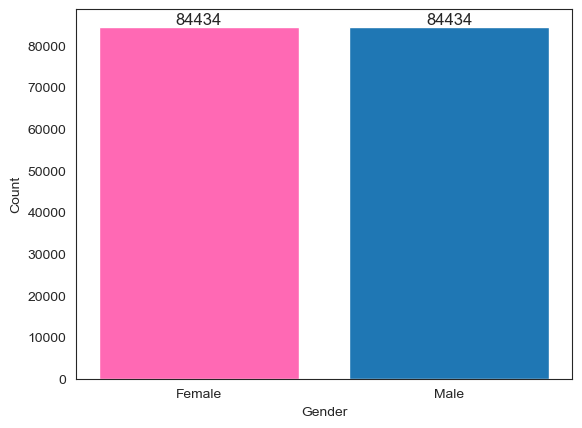

In [25]:
def plot_gender_histogram(df):
    # Zähle die Anzahl von Frauen und Männern
    counts = df['Male'].value_counts()

    # Plotte die Daten
    plt.bar(['Female', 'Male'], [counts[-1], counts[1]], color=['#ff69b4', '#1f77b4'])

    # Schreibe Text auf die Balken
    for i, v in enumerate([counts[-1], counts[1]]):
        plt.text(i, v, str(v), fontsize=12, ha='center', va='bottom')

    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()


def balance_column(csv_path, column_name):
    # Lade die CSV-Datei in einen DataFrame
    df = pd.read_csv(csv_path)

    # Zähle die Anzahl von -1 und 1
    counts = df[column_name].value_counts()

    # Finde den kleineren Wert
    min_count = min(counts.get(-1, 0), counts.get(1, 0))

    # Erstelle einen neuen DataFrame mit einer ausgeglichenen Anzahl von -1 und 1
    df_balanced = pd.concat([
        df[df[column_name] == -1].sample(min_count),
        df[df[column_name] == 1].sample(min_count)
    ], axis=0)

    return df_balanced


# Call the function with your csv file
balanced_df = balance_column(source_csv, "Male")
balanced_df.to_csv("balanced_gender.csv", index=False)

balanced_csv_path =r"data\balanced_gender.csv"
plot_gender_histogram(balanced_df)


## 4.2 Unausgeglichenheit zwischen Jungen und Alten Personendatensätzen ausgleichen

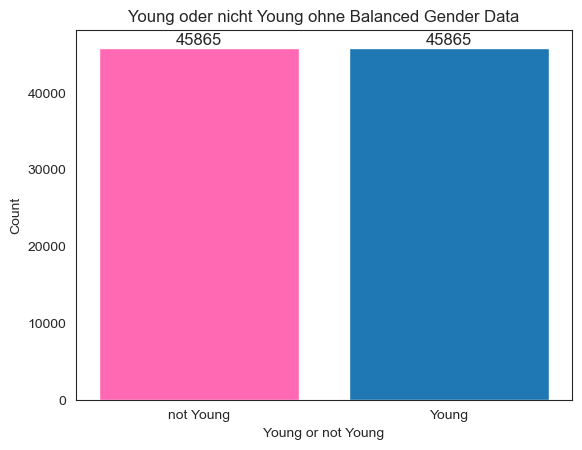

In [26]:
def plot_young_histogram(df):
    # Zähle die Anzahl von Frauen und Männern
    counts = df["Young"].value_counts()

    # Plotte die Daten
    plt.bar(['not Young', 'Young'], [counts[-1], counts[1]], color=['#ff69b4', '#1f77b4'])

    # Schreibe Text auf die Balken
    for i, v in enumerate([counts[-1], counts[1]]):
        plt.text(i, v, str(v), fontsize=12, ha='center', va='bottom')
    plt.title('Young oder nicht Young ohne Balanced Gender Data')
    plt.xlabel('Young or not Young')
    plt.ylabel('Count')
    plt.show()

young_balanced_csv = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\balanced_young.csv"
df_young_balanced = balance_column(source_csv, "Young")
df_young_balanced.to_csv("balanced_young.csv", index=False)
df_young_balanced = pd.read_csv(young_balanced_csv)

plot_young_histogram(df_young_balanced)



# 5. Datenverteilung Testen

## 5.1 Daten auf Normalverteilung testen

In [27]:
from scipy.stats import shapiro
from scipy.stats import kstest, uniform
import pandas as pd


def test_normal_distribution(data, column_name):
    # Führe den Shapiro-Wilk-Test durch
    stat, p = shapiro(data)

    # Überprüfe das Ergebnis
    if p > 0.05:
        print(f'Die Daten in der Spalte {column_name} folgen wahrscheinlich einer Normalverteilung.')
    else:
        print(f'Die Daten in der Spalte {column_name} folgen wahrscheinlich nicht einer Normalverteilung.')

# Call the function with your data
for column_name in df.columns:
    if pd.api.types.is_numeric_dtype(df[column_name]):
        test_normal_distribution(df[column_name], column_name)







Die Daten in der Spalte 5_o_Clock_Shadow folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Arched_Eyebrows folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Attractive folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Bags_Under_Eyes folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Bald folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Bangs folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Big_Lips folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Big_Nose folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Black_Hair folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Blond_Hair folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Blurry folgen wahrscheinlich nicht einer Normalverteilung.
Die Daten in der Spalte Brown_Hair folgen wahr

## 5.2 Daten auf Uniformverteilung testen

In [28]:
def test_uniform_distribution(data, column_name):
    # Generiere theoretische Werte für die Uniformverteilung
    theoretical_values = uniform.rvs(size=len(data))

    # Führe den KS-Test durch
    stat, p = kstest(data, theoretical_values)

    # Überprüfe das Ergebnis
    if p > 0.05:
        print(f'Die Daten in der Spalte {column_name} folgen wahrscheinlich einer Uniformverteilung.')
    else:
        print(f'Die Daten in der Spalte {column_name} wahrscheinlich nicht einer Uniformverteilung.')

# Call the function with your data
for column_name in df.columns:
    if pd.api.types.is_numeric_dtype(df[column_name]):
        test_uniform_distribution(df[column_name], column_name)

Die Daten in der Spalte 5_o_Clock_Shadow wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Arched_Eyebrows wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Attractive wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Bags_Under_Eyes wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Bald wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Bangs wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Big_Lips wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Big_Nose wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Black_Hair wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Blond_Hair wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Blurry wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Brown_Hair wahrscheinlich nicht einer Uniformverteilung.
Die Daten in der Spalte Bushy_E

## 5.3 Daten auf Binomialverteilung testen

In [29]:
from scipy.stats import chisquare, binom

def test_binomial_distribution(data, column_name, p):
    # Berechne die erwarteten Häufigkeiten
    n = len(data)
    expected_values = [n*p, n*(1-p)]

    # Berechne die beobachteten Häufigkeiten
    observed_values = [sum(data), n-sum(data)]

    # Führe den Chi-Quadrat-Anpassungstest durch
    stat, p_value = chisquare(f_obs=observed_values, f_exp=expected_values)

    # Überprüfe das Ergebnis
    if p_value > 0.05:
        print(f'Die Daten in der Spalte {column_name} folgen wahrscheinlich einer Binomialverteilung.')
    else:
        print(f'Die Daten in der Spalte {column_name} folgen wahrscheinlich nicht einer Binomialverteilung.')

# Call the function with your data
for column_name in df.columns:
    if pd.api.types.is_numeric_dtype(df[column_name]):
        test_binomial_distribution(df[column_name], column_name, p=0.5)

Die Daten in der Spalte 5_o_Clock_Shadow folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Arched_Eyebrows folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Attractive folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Bags_Under_Eyes folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Bald folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Bangs folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Big_Lips folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Big_Nose folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Black_Hair folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Blond_Hair folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte Blurry folgen wahrscheinlich nicht einer Binomialverteilung.
Die Daten in der Spalte 

# 6. Hier werden die Daten nun visualisiert. Dabei werden Datenvielfalt, Datenverteilung visualisiert. 

In [30]:
def detect_outliers_iqr_all_columns(csv_path):
    df = pd.read_csv(csv_path)
    outliers_report = []

    for column_name in df.columns:
        if np.issubdtype(df[column_name].dtype, np.number):  # Überprüfe, ob die Spalte numerisch ist
            Q1 = df[column_name].quantile(0.25)
            Q3 = df[column_name].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[column_name] < Q1 - 1.5 * IQR) | (df[column_name] > Q3 + 1.5 * IQR)]
            if not outliers.empty:
                outliers_report.append(f"Die Spalte '{column_name}' hat Ausreißer. Anzahl: {len(outliers)}")

    return "\n".join(outliers_report)

detect_outliers_iqr_all_columns(csv_path=csv_path)

"Die Spalte '5_o_Clock_Shadow' hat Ausreißer. Anzahl: 22516\nDie Spalte 'Bags_Under_Eyes' hat Ausreißer. Anzahl: 41446\nDie Spalte 'Bald' hat Ausreißer. Anzahl: 4547\nDie Spalte 'Bangs' hat Ausreißer. Anzahl: 30709\nDie Spalte 'Big_Lips' hat Ausreißer. Anzahl: 48785\nDie Spalte 'Big_Nose' hat Ausreißer. Anzahl: 47516\nDie Spalte 'Black_Hair' hat Ausreißer. Anzahl: 48472\nDie Spalte 'Blond_Hair' hat Ausreißer. Anzahl: 29983\nDie Spalte 'Blurry' hat Ausreißer. Anzahl: 10312\nDie Spalte 'Brown_Hair' hat Ausreißer. Anzahl: 41572\nDie Spalte 'Bushy_Eyebrows' hat Ausreißer. Anzahl: 28803\nDie Spalte 'Chubby' hat Ausreißer. Anzahl: 11663\nDie Spalte 'Double_Chin' hat Ausreißer. Anzahl: 9459\nDie Spalte 'Eyeglasses' hat Ausreißer. Anzahl: 13193\nDie Spalte 'Goatee' hat Ausreißer. Anzahl: 12716\nDie Spalte 'Gray_Hair' hat Ausreißer. Anzahl: 8499\nDie Spalte 'Mustache' hat Ausreißer. Anzahl: 8417\nDie Spalte 'Narrow_Eyes' hat Ausreißer. Anzahl: 23329\nDie Spalte 'No_Beard' hat Ausreißer. Anzahl:

In [31]:
def check_duplicates(csv_path):
    df = pd.read_csv(csv_path)
    duplicates = df.duplicated()
    if duplicates.any():
        print(f"Es gibt {duplicates.sum()} Duplikate in den Daten.")
    else:
        print("Es gibt keine Duplikate in den Daten.")

check_duplicates(csv_path=csv_path)

Es gibt keine Duplikate in den Daten.


In [32]:
def check_null_values(csv_path):
    df = pd.read_csv(csv_path)
    null_values = df.isnull().sum()
    if null_values.any():
        print(f"Es gibt Nullwerte in den Daten:\n{null_values}")
    else:
        print("Es gibt keine Nullwerte in den Daten.")

check_null_values(csv_path=csv_path)

Es gibt keine Nullwerte in den Daten.


In [33]:
# from great_expectations.data_context import DataContext

# context = DataContext('great_expectations.yml')

# # Load a batch of data
# batch = context.get_batch('my_datasource', 'my_expectation_suite', 'my_data')

# # Check if the data meets your expectations
# results = context.run_validation_operator('action_list_operator', assets_to_validate=[batch])

# # Print the results
# print(results)


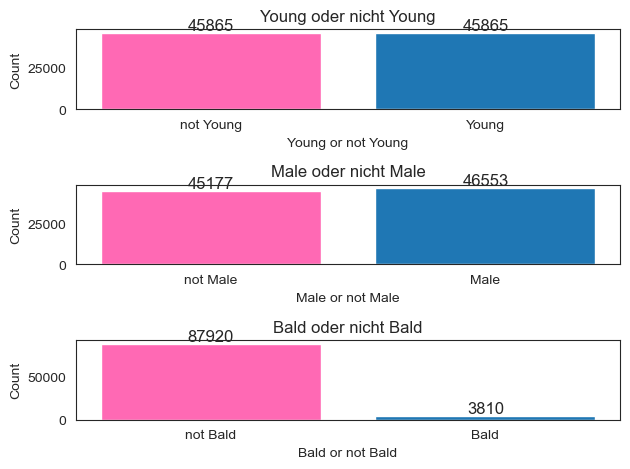

In [34]:
import matplotlib.pyplot as plt

def plot_histograms(df, columns):
    # Erstelle eine Figur und Achsen mit der gleichen Anzahl von Subplots wie Spalten
    fig, axs = plt.subplots(len(columns))

    # Für jede Spalte, erstelle ein Histogramm und füge es dem entsprechenden Subplot hinzu
    for ax, column in zip(axs, columns):
        # Zähle die Anzahl von Werten in der aktuellen Spalte
        counts = df[column].value_counts()

        # Plotte die Daten
        ax.bar(['not ' + column, column], [counts[-1], counts[1]], color=['#ff69b4', '#1f77b4'])

        # Schreibe Text auf die Balken
        for i, v in enumerate([counts[-1], counts[1]]):
            ax.text(i, v, str(v), fontsize=12, ha='center', va='bottom')
        ax.set_title(column + ' oder nicht ' + column)
        ax.set_xlabel(column + ' or not ' + column)
        ax.set_ylabel('Count')

    # Zeige alle Plots an
    plt.tight_layout()
    plt.show()

# Call the function with your data and the columns you want to plot
plot_histograms(df_young_balanced, ['Young', 'Male', 'Bald'])